# Mapping Covid-19 Positivity Rates and Testing Rates

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import matplotlib as mpl
pd.set_option('display.max_columns', 100)

In [65]:
# Import Chicago zip code boundaries
zip_boundaries = gpd.read_file('Boundaries - ZIP Codes/geo_export_36539c7f-c059-4101-bae4-2a14800742b8.shp')
zip_boundaries.zip = zip_boundaries.zip.astype(int)
zip_boundaries = zip_boundaries[(zip_boundaries.zip>=60601)&(zip_boundaries.zip<=60700)]
zip_boundaries.rename(columns={'zip':'ZCTA'}, inplace=True)

In [75]:
# Import complete dataframe for mapping
df = pd.read_pickle(r'complete_df.pickle')

In [76]:
# Convert decimals to numbers
df['posRate'] = df['posRate']*100
df['2weeksprior'] = df['2weeksprior']*100
df['testpercent'] = df['testpercent']*100
df['percent_change_pos_rate'] = df['percent_change_pos_rate']*100

In [111]:
# Merge census df and other features into zip boundaries
complete_df = pd.merge(zip_boundaries, df, on='ZCTA')

In [112]:
complete_df = complete_df.sort_values(by='posRate')

In [113]:
complete_df[['posRate', '2weeksprior', 'percent_change_pos_rate']].describe()

,posRate,2weeksprior,percent_change_pos_rate
count,57.000000,57.000000,57.000000
mean,8.857329,5.708453,3.148876
std,3.851460,2.928079,1.599413
min,1.721349,0.895625,-1.734364
25%,6.305624,3.615196,2.441750
50%,7.744381,5.166846,2.973143
75%,11.097179,6.905371,3.720833
max,19.930285,13.816103,7.545492


In [80]:
complete_df.testpercent.describe()

count    57.000000
mean      7.172714
std       2.411565
min       3.618897
25%       5.516205
50%       6.596806
75%       8.650717
max      18.240823
Name: testpercent, dtype: float64

In [86]:
complete_df.drop_duplicates(subset='ZCTA', inplace=True)

In [87]:
import mapclassify as mc
from mapclassify import Quantiles, UserDefined
import contextily as ctx
import matplotlib as mpl
streets = gpd.read_file('Street Center Lines/geo_export_7dc21389-c9d3-4a8a-a9b1-8e20ca2e01dc.shp')
streets = streets[streets.geometry.notnull()]

## Positivity Rates by Zip Code
2-Week average positivity rate between 10/18 and 10/31

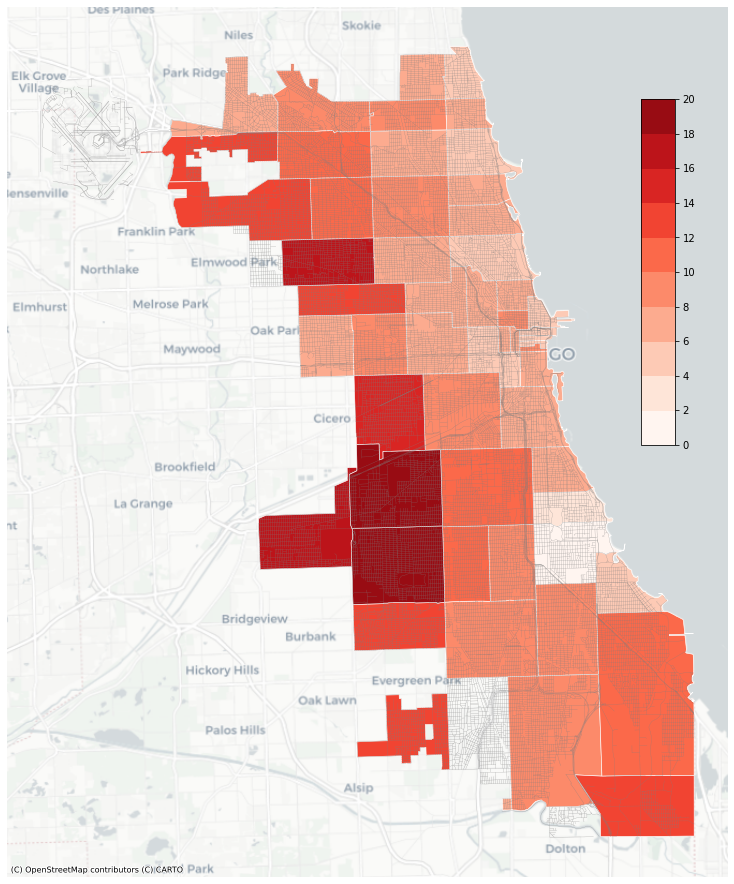

In [91]:
# Covid Positivity Rates by Zip Code
fig, ax = plt.subplots(figsize=(16,16))
# converting Chicago streets file to crs using Chicago-specific epsg code
streets.to_crs(epsg=26971).plot(ax=ax, color = 'grey', linewidth= 0.2)

# Creating color scheme for map
cm = plt.get_cmap('Reds')
scheme = [cm(i / 10) for i in range(0, 10)]
bins = list(np.arange(0, 22, 2))

# Plotting map and re-assigning continuous variables to groupbed bins
complete_df.to_crs(epsg=26971).assign(buckets = UserDefined(complete_df.posRate, bins).yb).plot(column='buckets', 
                                         cmap=mpl.colors.ListedColormap(scheme), linewidth=.6, edgecolor='white',
                                         categorical=True, ax=ax)

# Adding basemap (surrounding area)
ctx.add_basemap(ax, crs='EPSG:26971', source=ctx.providers.CartoDB.Positron)
ax.axis('off')

# Creating color bar legend
ax_legend = fig.add_axes([0.75, 0.5, 0.03, 0.3], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()

In [114]:
# Top 5 Zip Codes with highest Positivity Rates
complete_df.sort_values(by='posRate', ascending=False).head()

,objectid,shape_area,shape_len,ZCTA,geometry,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,2weeksprior,testpercent,posRate,percent_change_pos_rate
51,56.0,2.117553e+08,63253.238669,60632,"POLYGON ((-87.69479 41.83008, -87.69472 41.830...",91039.0,30.9,42758.0,3.653544,0.839574,0.018563,0.517514,0.254913,0.228045,0.180299,0.047881,0.036292,0.296587,0.007247,12.384793,5.357045,19.930285,7.545492
53,58.0,2.111148e+08,58701.325375,60629,"POLYGON ((-87.68306 41.75786, -87.68306 41.757...",111850.0,31.2,42019.0,3.514312,0.710165,0.197389,0.420465,0.194099,0.187966,0.151034,0.081538,0.038820,0.281618,0.017406,13.816103,5.710326,18.365430,4.549327
5,39.0,1.661663e+08,67710.646739,60638,"POLYGON ((-87.74347 41.81876, -87.74346 41.818...",58797.0,37.7,67984.0,2.910887,0.517713,0.031923,0.724272,0.083865,0.057724,0.086705,0.040087,0.046567,0.306308,0.008641,12.868410,5.541099,17.894414,5.026004
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",90517.0,33.1,44150.0,3.539969,0.779279,0.138615,0.432659,0.220334,0.208292,0.185561,0.041694,0.054343,0.310141,0.006200,11.912974,5.438757,16.981515,5.068541
52,57.0,1.552855e+08,53406.915617,60623,"POLYGON ((-87.69479 41.83008, -87.69486 41.830...",85979.0,30.3,31634.0,3.438472,0.661371,0.312332,0.383850,0.220472,0.218995,0.213823,0.050059,0.041638,0.264099,0.003104,9.018736,4.858163,15.561408,6.542672


### Community Areas with Highest Positivity Rates
The Centers for Disease Control and the World Health Organization suggest that an area with a positivity rate above 5 percent may suggest that there is either **not enough testing in that area** or **the area is experiencing a surge in COVID transmission rates.** 
- Brighton Park (60632): Primarily Latinx Neighborhood on Southwest Side (84 percent Latinx) with 19.9 percent positivity rate.
- Chicago Lawn (60629): Primarily Latinx neighborhood in Chicago (71 percent Latinx) with 18.4 percent positivity rate.
- Clearing (60638): Primarily White and Latinx community near Midway (airport) with fairly high percentage of essential workers (30.6 percent) and a positivity rate of 17.9 percent.
- Belmont Cragin (60639): Primarily Latinx neighborhood (77.9 percent latinx) with 31.4 percent essential workers and a positivity rate of 17 percent.
- Little Village (60623): Primarily Mexican neighborhood on the Southwest Side (66.1 percent Latinx) with positivity rate of 15.6 percent.

## Testing Rate by Zip Code
Testing per capita for the 2-week period between 10/18 and 10/31.

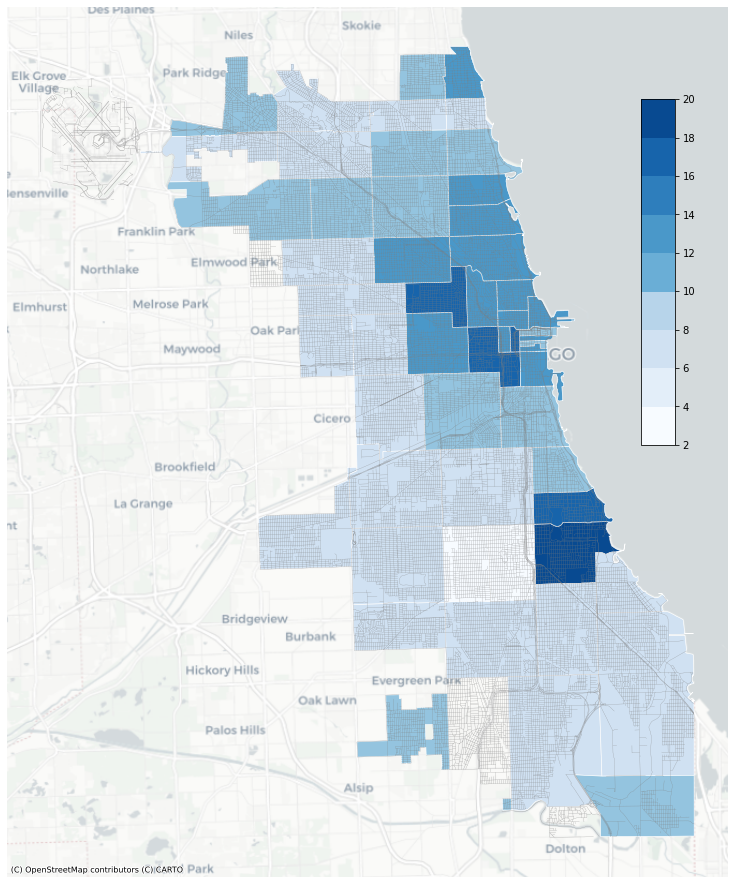

In [93]:
# Testing rates by zip code
fig, ax = plt.subplots(figsize=(16,16))
streets.to_crs(epsg=26971).plot(ax=ax, color = 'grey', linewidth= 0.2)

# Creating color scheme
cm = plt.get_cmap('Blues')
scheme = [cm(i / 10) for i in range(0, 10)]
bins = list(np.arange(2, 22, 2))

# Plotting testing per capita and reassigning continuous values to bins
complete_df.to_crs(epsg=26971).assign(buckets = UserDefined(complete_df.testpercent, bins).yb).plot(column='buckets', 
                                         cmap=mpl.colors.ListedColormap(scheme), linewidth=.6, edgecolor='white',
                                         categorical=True, ax=ax)
ctx.add_basemap(ax, crs='EPSG:26971', source=ctx.providers.CartoDB.Positron)
ax.axis('off')


# Creating color bar
ax_legend = fig.add_axes([0.75, 0.5, 0.03, 0.3], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()


In [115]:
# Zip codes with highest testing rates
complete_df.sort_values(by='testpercent', ascending=False).head()

,objectid,shape_area,shape_len,ZCTA,geometry,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,2weeksprior,testpercent,posRate,percent_change_pos_rate
55,60.0,1.254243e+08,52377.854541,60637,"POLYGON ((-87.57691 41.79511, -87.57700 41.795...",47454.0,30.7,28785.0,2.467450,0.028259,0.762064,0.161841,0.042251,0.007038,0.071315,0.071880,0.065853,0.183335,0.007019,0.895625,18.240823,1.721349,0.825724
41,29.0,6.466429e+07,39143.639517,60607,"POLYGON ((-87.63962 41.87677, -87.63928 41.876...",29591.0,30.1,93508.0,2.307650,0.083032,0.145112,0.581697,0.121152,0.009091,0.033990,0.046061,0.087155,0.239025,0.010535,3.426295,11.114866,5.868045,2.441750
43,31.0,6.766411e+06,12040.440235,60606,"POLYGON ((-87.63397 41.88753, -87.63397 41.887...",3101.0,37.2,131477.0,1.488004,0.062883,0.023541,0.727507,0.108352,0.017736,0.023632,0.019026,0.069332,0.253467,0.006805,2.958580,10.641728,7.575758,4.617178
8,8.0,6.656545e+07,38321.313769,60615,"POLYGON ((-87.58103 41.80421, -87.58089 41.804...",41563.0,33.8,44111.0,1.967759,0.061906,0.552222,0.301037,0.094435,0.021052,0.069929,0.048529,0.063157,0.201381,0.006392,1.793492,10.203787,2.475831,0.682339
2,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",52793.0,31.7,93988.0,2.255147,0.219328,0.067301,0.784460,0.067111,0.024189,0.063135,0.021726,0.079783,0.252344,0.005654,3.920695,10.003220,6.305624,2.384929


### Community Areas with Highest Testing Rates
- Hyde Park/Woodlawn (UChicago Campus) (60637): Primarily Black neighborhoods home to the UChicago Campus and student body. The testing rate here is 18.2 percent - much higher than most other zip codes in the city.
- West Loop (60607): Upscale neighborhoods directly west of downtown home to students at UIC and medial students in the Illinois Medical District. The testing rate here is 11.1 percent.
- Small Sliver of Loop/West Loop (60606): Very welathy area in the downtown/financial district of the city where most residents are White and few unemployed. The tests administered in this area as a percentage of residents is 10.6 percent.
- East Hyde Park (60615): The neighborhood directly north of Hyde Park and the UChicago campus. The testing rate in this area is 10.2 percent.
- Wicker Park/West Town (60622): Urban hipster area located on the Northwest side of the city. This area is home to a number of students, recent graduates, and families. The testing rate here is 10 percent.

## Mapping Percent Change in Covid Positivity Cases
The map below shows the percentage-point change in positivity rates from the 2 weeks at the start of October (10/4 - 10/17) to the last 2 weeks (10/18 - 10/31). Percentage point difference was calculated by subtracting the 2-week average positivity rate of the earlier period from the later period. 

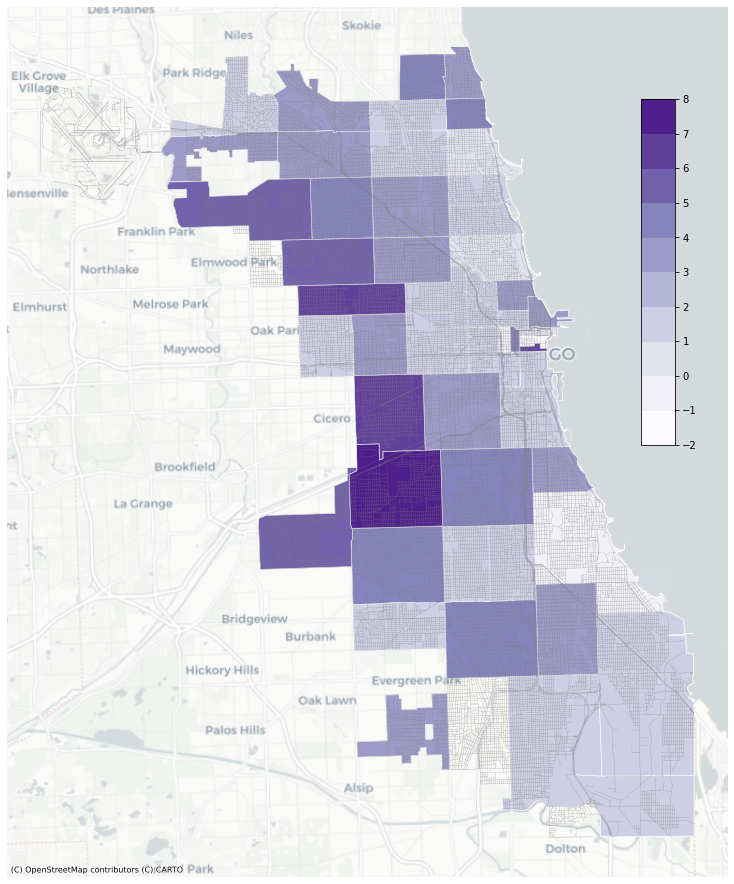

In [107]:
# Percent change from previous 2-week period
fig, ax = plt.subplots(figsize=(16,16))
streets.to_crs(epsg=26971).plot(ax=ax, color = 'grey', linewidth= 0.2)

# Creating color scheme
cm = plt.get_cmap('Purples')
scheme = [cm(i / 10) for i in range(0, 10)]
bins = list(np.arange(-2,9,1))

# Plotting testing per capita and reassigning continuous values to bins
complete_df.to_crs(epsg=26971).assign(buckets = UserDefined(complete_df.percent_change_pos_rate, bins).yb).plot(column='buckets', cmap=mpl.colors.ListedColormap(scheme), linewidth=.6, edgecolor='white',
                                         categorical=True, ax=ax)
ctx.add_basemap(ax, crs='EPSG:26971', source=ctx.providers.CartoDB.Positron)
ax.axis('off')

# Creating color bar
ax_legend = fig.add_axes([0.75, 0.5, 0.03, 0.3], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()


In [116]:
complete_df.sort_values(by='percent_change_pos_rate', ascending=False).head()

,objectid,shape_area,shape_len,ZCTA,geometry,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,2weeksprior,testpercent,posRate,percent_change_pos_rate
51,56.0,2.117553e+08,63253.238669,60632,"POLYGON ((-87.69479 41.83008, -87.69472 41.830...",91039.0,30.9,42758.0,3.653544,0.839574,0.018563,0.517514,0.254913,0.228045,0.180299,0.047881,0.036292,0.296587,0.007247,12.384793,5.357045,19.930285,7.545492
52,57.0,1.552855e+08,53406.915617,60623,"POLYGON ((-87.69479 41.83008, -87.69486 41.830...",85979.0,30.3,31634.0,3.438472,0.661371,0.312332,0.383850,0.220472,0.218995,0.213823,0.050059,0.041638,0.264099,0.003104,9.018736,4.858163,15.561408,6.542672
27,48.0,4.294902e+06,12245.808402,60604,"POLYGON ((-87.63376 41.87924, -87.63375 41.879...",782.0,32.4,116250.0,1.632568,0.043478,0.056266,0.634271,0.162404,0.008951,0.003836,0.057545,0.067775,0.125320,0.008123,2.666667,8.439898,9.090909,6.424242
3,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895...",63218.0,33.0,38083.0,3.216710,0.424879,0.520627,0.166946,0.104559,0.100161,0.159765,0.056550,0.075437,0.267819,0.007784,6.881903,5.223196,12.992126,6.110223
47,52.0,1.940626e+08,77647.318007,60634,"POLYGON ((-87.76625 41.93128, -87.76661 41.931...",75995.0,39.1,66741.0,2.909902,0.382459,0.021765,0.784907,0.152813,0.063109,0.113767,0.025515,0.065386,0.314218,0.012243,8.483087,6.281992,13.866778,5.383692


### Community Areas with Largest Increases in 2-week Average positivity Rate
- Brighton Park (60632): Predominantly Latinx community on the West side with a roughly 7.5 percentage-point increase in the 2-week positivity rate.
- Little Village (60623): Primarily Latinx community on the Southwest side with a 6.5 percentage-point increase in the 2-week average positivity rate.
- Chicago Loop (60604): Small portion of Chicago's loop community home to students, offices and few residents. This zip code experienced a 6.4 percentage point increase in positivity rate.
- Humboldt Park/Austin (60651): Primarily Black and Latinx communities with a relatively high percentage of essential workers. This community area saw a 6.1 percentage point increase in the positivity rate.
- Dunning (60634): Primarily white, middle-class neighborhood on the West side that had a 5.4 percentage-point increase in positivity rates.

